In [67]:
import os
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [68]:
def load_and_preprocess(data_dir):
    all_data = []

    for country in os.listdir(data_dir):
        country_path = os.path.join(data_dir, country)
        if not os.path.isdir(country_path):
            continue
        
        for category_file in os.listdir(country_path):
            category_path = os.path.join(country_path, category_file)
            if not category_file.endswith(".json"):
                continue

            with open(category_path, 'r') as f:
                channels = json.load(f)
            for channel in channels:
                videos = channel["videos"]
                for video in videos:
                    video['country'] = country
                    video['category'] = os.path.splitext(category_file)[0]
                    all_data.append(video)

    df = pd.DataFrame(all_data)
    df['date'] = pd.to_datetime(df['date'])

    min_date = df['date'].min()
    df['normalized_date'] = (df['date'] - min_date).dt.total_seconds() / (24 * 60 * 60)

    return df

In [69]:
data_dir = "../data/videos/preprocessed"
df = load_and_preprocess(data_dir)

In [70]:
df.head()

,video_id,title,description,category,thumbnail,author,author_id,views,likes,comments,date,country,normalized_date
0,mL-qg25zWSM,what today holiday shorts mashaandthebear day ...,Nowy odcinek 🎩 Dzień dobrych manier 🌟 ➡️ Już 2...,Film & Animation,https://i.ytimg.com/vi/mL-qg25zWSM/hqdefault.jpg,Masza i Niedźwiedź,UCAQ0PY25DvWFsukS8fOh-rA,3263,101,0,2024-11-19 08:00:39+00:00,poland,4767.700220
1,ir9AWj2Gmss,mama bear ready play masha bear new episode al...,Nowy odcinek 🎩 Dzień dobrych manier 🌟 ➡️ Już 2...,Film & Animation,https://i.ytimg.com/vi/ir9AWj2Gmss/hqdefault.jpg,Masza i Niedźwiedź,UCAQ0PY25DvWFsukS8fOh-rA,28352,84,0,2024-11-19 08:00:30+00:00,poland,4767.700116
2,flTcfjyQgRQ,new episode 2024 mama bear day good manners ep...,Masza i Niedźwiedź ❤️️ Wszystkie odcinki: http...,Film & Animation,https://i.ytimg.com/vi/flTcfjyQgRQ/hqdefault.jpg,Masza i Niedźwiedź,UCAQ0PY25DvWFsukS8fOh-rA,0,7,0,2024-11-18 12:15:55+00:00,poland,4766.877488
3,tyZnpk-D-Z0,live watch seasons day mom bear masha bear,Masza i Niedźwiedź ❤️️ Wszystkie odcinki: http...,Film & Animation,https://i.ytimg.com/vi/tyZnpk-D-Z0/hqdefault.jpg,Masza i Niedźwiedź,UCAQ0PY25DvWFsukS8fOh-rA,17118,88,0,2024-11-17 20:45:20+00:00,poland,4766.231250
4,Vt_nl9oZ5_A,when ve getting ready little long shorts masha...,🍒👱‍♀️ Konfiturki 🐻🍓 Odcinek 6 https://youtu.be...,Film & Animation,https://i.ytimg.com/vi/Vt_nl9oZ5_A/hqdefault.jpg,Masza i Niedźwiedź,UCAQ0PY25DvWFsukS8fOh-rA,4898,185,0,2024-11-17 08:00:18+00:00,poland,4765.699977


In [71]:
def extract_features(df):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_features = tfidf_vectorizer.fit_transform(df['title'])
    combined_features = np.hstack((tfidf_features.toarray(), df[['normalized_date']].values))
    return combined_features, tfidf_vectorizer

combined_features, tfidf_vectorizer = extract_features(df)

In [72]:
def perform_clustering(df, features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(features)
    return df, kmeans

df, kmeans = perform_clustering(df, combined_features, n_clusters=5)

In [73]:
def analyze_clusters(df):
    stats = df.groupby(['country', 'category', 'cluster']).agg({
        'video_id': 'count',
        'normalized_date': ['min', 'max', 'mean'],
        'date': ['min', 'max']
    }).reset_index()

    stats.columns = ['country', 'category', 'cluster', 'video_count', 'days_min', 'days_max', 'days_mean', 'date_min', 'date_max']
    return stats

In [74]:
cluster_stats = analyze_clusters(df)

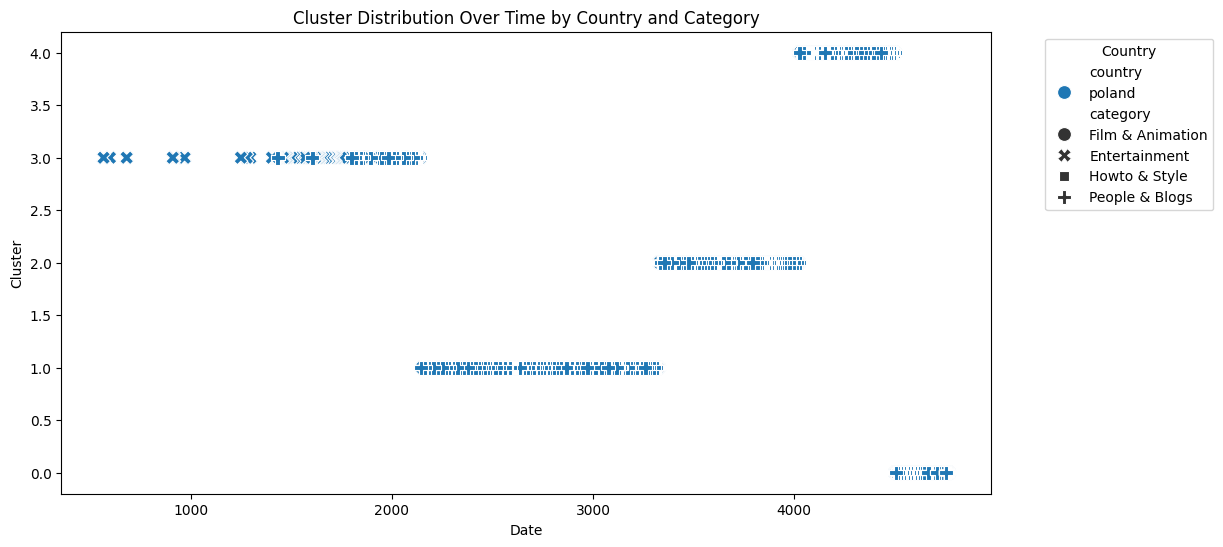

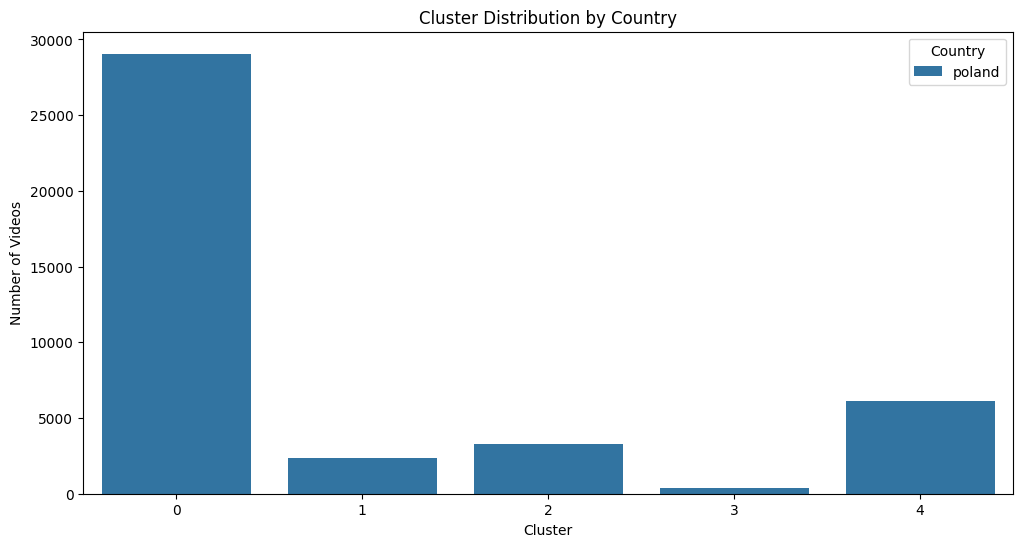

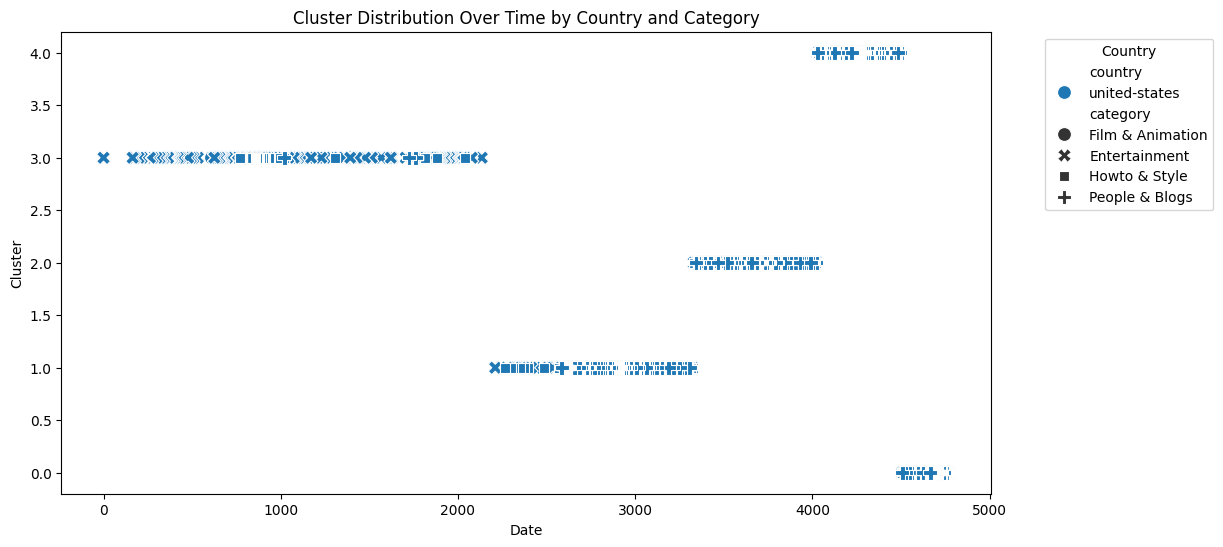

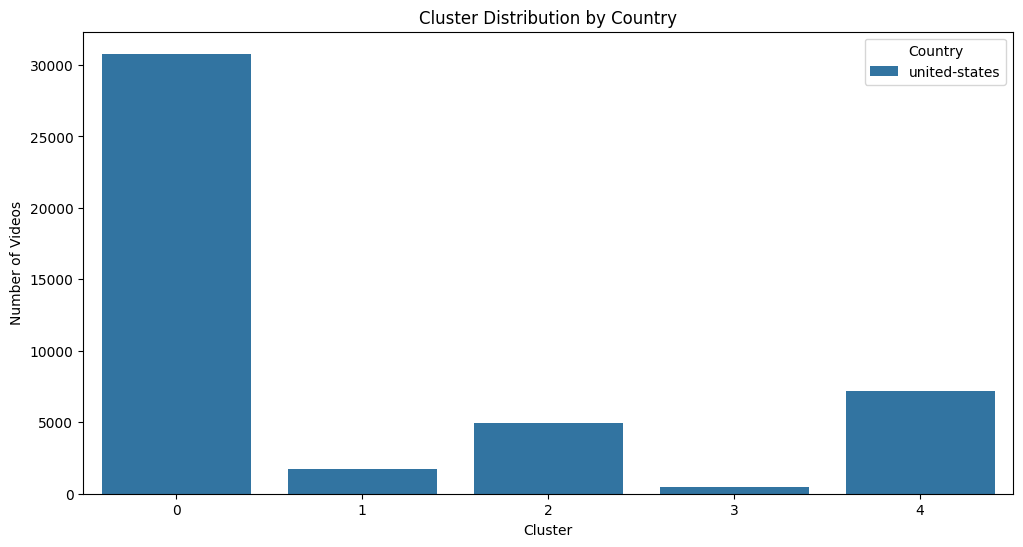

In [ ]:
def visualize_clusters(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=df, 
        x='normalized_date', 
        y='cluster', 
        hue='country', 
        style='category', 
        palette='tab10', 
        s=100
    )
    plt.title('Cluster Distribution Over Time by Country and Category')
    plt.xlabel('Date')
    plt.ylabel('Cluster')
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=df, 
        x='cluster', 
        hue='country', 
        palette='tab10'
    )
    plt.title('Cluster Distribution by Country')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Videos')
    plt.legend(title='Country')
    plt.show()

for country in df['category'].unique():
    country_df = df[df['country'] == country]
    visualize_clusters(country_df)